# Setting up a basic ReAct Agent in LangGraph

In [142]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun  # Initialize the tool
search_ddg_tool = DuckDuckGoSearchRun()

tools = [search_ddg_tool]

In [10]:
search_ddg_tool.run('sinan ozdemir')

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


'Sinan Ozdemir is a data scientist, NLP expert, lecturer, mathematician, and accomplished author. He is currently the founder and CTO of LoopGenius, transforming the way entrepreneurs and startups market their products and services. Simultaneously, he is providing advisory services in AI and LLMs to VCs including Tola Capital. ... Sinan Ozdemir is a mathematician, data scientist, NLP expert, lecturer, and accomplished author. He is currently applying my extensive knowledge and experience in AI and Large Language Models (LLMs) as the founder and CTO of LoopGenius, transforming the way entrepreneurs and startups market their products and services. Sinan Ozdemir is a mathematician, data scientist, NLP expert, lecturer, and accomplished author. He is currently applying my extensive knowledge and experience in AI and Large Language Models (LLMs) as the founder and CTO of LoopGenius, transforming the way entrepreneurs and startups market their products and services. Instructor Sinan Ozdemir 

In [37]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, state_modifier='Today is April 9th, 2025')  # true as of 4/9/2025 ;)

In [28]:
response = agent_executor.invoke({"messages": [("user", "Who is the current Ravens QB?")]})

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


In [29]:
response['messages'][-1].content

'The current quarterback for the Baltimore Ravens is Lamar Jackson. He has been with the team since being drafted in 2018 and is a two-time NFL Most Valuable Player (MVP).'

In [38]:
# if I didn't put the date in, it would use a past year like 2023 as thr query instead of
#  {"query":"current Baltimore Ravens quarterback 2025"}
for event in agent_executor.stream({"messages": [("user", "Who is the current Ravens QB?")]}):
    print(event)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MW4BOWSXcsIC9dtIu2xVzTgU', 'function': {'arguments': '{"query":"current Baltimore Ravens quarterback 2025"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 91, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-78b595f7-7e97-4ab9-9f14-740702d66c19-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current Baltimore Ravens quarterback 2025'}, 'id': 'call_MW4BOWSXcsIC9dtIu2xVzTgU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'output_tokens': 24, 'total_tokens': 

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content="The Ravens carry two quarterbacks on their active roster. Rookie quarterback Devin Leary is a member of Baltimore's practice squad. Leary was a sixth-round selection by the Ravens in the 2024 NFL ... The most respected source for NFL Draft info among NFL Fans, Media, and Scouts, plus accurate, up to date NFL Depth Charts, Practice Squads and Rosters. Here's how the 2025 depth chart shapes up at this point, with more free agency additions still to come and 11 draft picks in the Ravens' possession. Quarterback Starter: Lamar Jackson Find out the list of the 32 NFL quarterbacks currently in 2025. The NFL starting quarterbacks are one of the most important players in every team and you know what it means to have the best in your team. List of the 32 NFL quarterbacks current in alphabetical order . A. Allen Brandon (San Francisco 49ers) ... (Baltimore Ravens) Johnson Josh ... The Baltimore Ravens brought in former Dallas Cowboy Cooper Rush as a b

In [40]:
print(event['agent']['messages'][-1].content)

As of now, the starting quarterback for the Baltimore Ravens is Lamar Jackson. The team also has Cooper Rush as a backup quarterback.


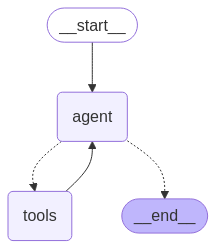

In [25]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [27]:
response = agent_executor.invoke({"messages": [("user", "Who is Sinan Ozdemir?")]})

print(response['messages'][-1].content)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


Sinan Ozdemir is a prominent data scientist, NLP (Natural Language Processing) expert, lecturer, and author. He currently serves as the founder and CTO of LoopGenius, where he focuses on transforming marketing strategies for entrepreneurs and startups. In addition to his role at LoopGenius, he provides advisory services in AI and Large Language Models (LLMs) to venture capital firms, including Tola Capital.

Ozdemir has previously lectured on Data Science at Johns Hopkins University and has authored several textbooks on data science and machine learning. He is recognized for his extensive knowledge and experience in AI and is actively involved in the development of modern NLP pipelines and transformer architectures.


# Turn our ReAct Agent into a Chat

In [62]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage

In [ ]:
class ConvoState(MessagesState):
    # MessagesState already has messages in it
    end: bool

def get_user_input(state):
    user_msg = input("\n🧑 You: ")
    if user_msg.strip().lower() == "exit":
        return {'end': True}
    return {"messages": HumanMessage(content=user_msg)}

def run_agent(state):
    response = agent_executor.invoke({"messages": state["messages"]})
    print(f"\n🤖 Agent: {response['messages'][-1].content}")
    return {"messages": AIMessage(content=response['messages'][-1].content)}

graph_builder = StateGraph(ConvoState)
graph_builder.add_node("get_user_input", get_user_input)
graph_builder.add_node("run_agent", run_agent)

graph_builder.set_entry_point("get_user_input")
graph_builder.add_conditional_edges(
    "get_user_input", 
    lambda state: 'end' if state.get('end') else 'go',
    {
        'end': END,
        'go': 'run_agent'
    }
)
graph_builder.add_edge("run_agent", "get_user_input")

graph = graph_builder.compile()

In [85]:

print("💬 Start chatting with the agent! Type 'exit' to stop.")
graph.invoke({"messages": []})

💬 Start chatting with the agent! Type 'exit' to stop.



🧑 You:  hi I'm Sinan



🤖 Agent: Hi Sinan! How can I assist you today?



🧑 You:  what's my name



🤖 Agent: Your name is Sinan. How can I help you today?



🧑 You:  what's the weather in SF today?


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(



🤖 Agent: Today in San Francisco, the weather is currently around 50°F (10°C) with a humidity level of 79%. The highs are expected to range from the low 60s in areas like Pacifica and Half Moon Bay to mid-70s in places like Redwood City. Overall, it's a cool day in the city. If you need more specific details or forecasts, just let me know!



🧑 You:  what is today?



🤖 Agent: Today is April 9th, 2025. How else can I assist you?



🧑 You:  exit


{'messages': [HumanMessage(content="hi I'm Sinan", additional_kwargs={}, response_metadata={}, id='0f540d97-b854-4fcf-b2aa-0be187289f28'),
  AIMessage(content='Hi Sinan! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='ced2fa62-6281-40e2-aa49-28f025fb7cae'),
  HumanMessage(content="what's my name", additional_kwargs={}, response_metadata={}, id='d7e77360-1014-4ee8-9213-4424021c0be4'),
  AIMessage(content='Your name is Sinan. How can I help you today?', additional_kwargs={}, response_metadata={}, id='4fb8d779-00e3-42c3-a4a6-ca8f2c945f56'),
  HumanMessage(content="what's the weather in SF today?", additional_kwargs={}, response_metadata={}, id='d1e3b8d2-1900-43a2-b628-b8d7b61d7779'),
  AIMessage(content="Today in San Francisco, the weather is currently around 50°F (10°C) with a humidity level of 79%. The highs are expected to range from the low 60s in areas like Pacifica and Half Moon Bay to mid-70s in places like Redwood City. Overall, it's a cool day in the

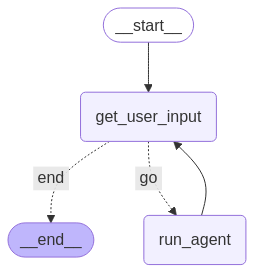

In [86]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))